In [1]:
using Pkg
Pkg.activate(".")
using Distributions
using Ipopt
using Random
using SVDD
using JuMP
using MLKernels

In [2]:
using Plots

In [3]:
function Plots.plot(m::OCClassifier, prec=0, title="")
    r = range(-0.5, 1.5, length = 100)
    grid = hcat([[x,y] for x in r for y in r]...)
    grid_predictions = SVDD.predict(m, grid)
    predictions = SVDD.predict(m, m.data)
    data = m.data
    grid_p = grid_predictions .- prec
    contourf(r, r, reshape(grid_p , length(r), length(r)), levels=range(0, maximum(grid_predictions), length=20), color=:blues)
    out = predictions .> prec
    scatter!(data[1, .!out], data[2, .!out], color=[:white])
    scatter!(data[1, out], data[2, out], color=[:red])
    contour!(r, r, reshape(grid_p , length(r), length(r)), levels=[0], linewidth=2, color=:black, cbar=false, legend=false)
end

Generate some test data:

In [4]:
solver = optimizer_with_attributes(Ipopt.Optimizer, "print_level" => 0)
Random.seed!(42);

In [5]:
n = 100
d1 = [[o, (5.5(o-0.5)^2 + rand() * 0.3) + 0.5] for o in rand(Truncated(Normal(), 0.2, 0.8), n)]
d2 = [[o, -(5.5(o-0.5)^2 + rand() * 0.3) + 0.5] for o in rand(Truncated(Normal(), 0.2, 0.8), n)]
d3 = [reshape(rand(70), 2, 35)]
dummy_data = hcat(d1..., d2..., d3...)
labels = fill(:U, size(dummy_data,2));

Define plotting function:

# Vanilla SVDD

In [6]:
model = SVDD.VanillaSVDD(dummy_data)
init_strategy = SVDD.SimpleCombinedStrategy(SVDD.FixedGammaStrategy(MLKernels.GaussianKernel(15)), SVDD.FixedCStrategy(0.01))
SVDD.initialize!(model, init_strategy)
SVDD.fit!(model, solver);


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************



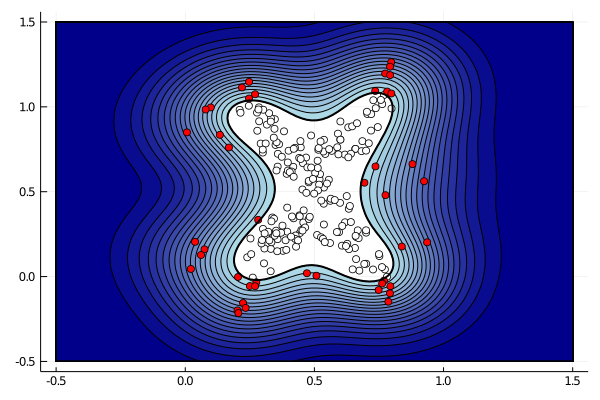

In [7]:
Plots.plot(model)

# SVDDNeg

Set the learning pools to to exclude the top banana as outliers:

In [8]:
pools = copy(labels)
pools[1:n] .= :Lout;

In [9]:
model = SVDD.SVDDneg(dummy_data, pools)
init_strategy = SVDD.SimpleCombinedStrategy(SVDD.FixedGammaStrategy(MLKernels.GaussianKernel(15)), SVDD.FixedCStrategy(0.015))
SVDD.initialize!(model, init_strategy)
SVDD.set_adjust_K!(model, true)
SVDD.fit!(model, solver);

[info | SVDD]: Adjusting Kernel Matrix.
[info | SVDD]: [ADJUST KERNEL] Maximum adjustemt of kernel matrix entry is 9.159339953157541e-15. The sum of adjustments is 4.676799124652367e-11


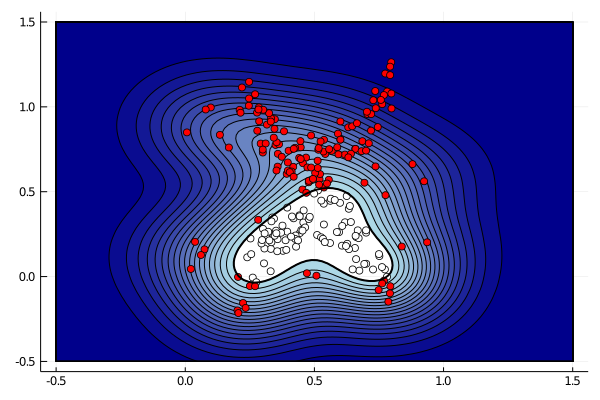

In [10]:
Plots.plot(model)

# SSAD

In [11]:
pools = copy(labels)
pools[dummy_data[2,:] .> .8] .= :Lin
pools[2n+1:end] .= :Lout;

In [12]:
model = SVDD.SSAD(dummy_data, pools)
init_strategy = SVDD.SimpleCombinedStrategy(SVDD.FixedGammaStrategy(MLKernels.GaussianKernel(15)), SVDD.FixedCStrategy(0.01))
SVDD.set_kappa!(model, 0.5)
SVDD.initialize!(model, init_strategy)
SVDD.set_adjust_K!(model, true)
SVDD.fit!(model, solver);

[info | SVDD]: Adjusting Kernel Matrix.
[info | SVDD]: [ADJUST KERNEL] Maximum adjustemt of kernel matrix entry is 9.159339953157541e-15. The sum of adjustments is 4.676799124652367e-11


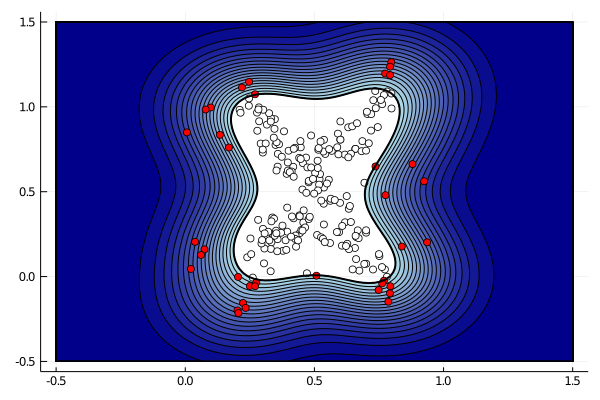

In [13]:
plot(model)

Label all points with y < 0.1 as outliers and rerun.

In [14]:
pools[dummy_data[2,:] .< 0.1] .= :Lout

SVDD.set_pools!(model, pools)
SVDD.fit!(model, solver);

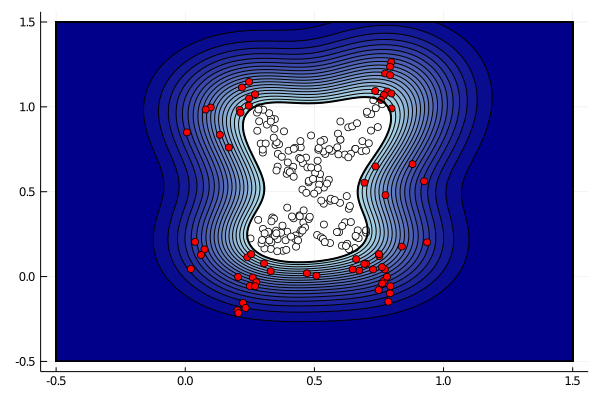

In [15]:
plot(model)